 # Step 3: Initial Simulation Model - Verification
# 
# This notebook implements the verification simulation with:
# - 3 containers produced over 24 hours
# - 1 truck and 1 crane

In [3]:
# Import required libraries
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from collections import defaultdict
import logging
from dataclasses import dataclass
from typing import List, Dict, Optional
import json

# Set random seed for reproducibility
np.random.seed(42)

# Configure visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [4]:
# ### 1.1 Entity Definitions

# %%
@dataclass
class Container:
    """Entity: Container (FEU - 40ft equivalent unit)"""
    id: int
    origin: str = "Gold Mine"
    destination: str = "Hamburg"
    created_time: float = 0.0
    current_location: str = "Gold Mine"
    status_history: List[Dict] = None
    
    def __post_init__(self):
        if self.status_history is None:
            self.status_history = []
    
    def update_status(self, time: float, location: str, activity: str):
        """Update container status and location"""
        self.current_location = location
        self.status_history.append({
            'time': time,
            'location': location,
            'activity': activity
        })

@dataclass
class Truck:
    """Entity: Truck for container transport"""
    id: int
    capacity: int = 1  # FEUs
    current_load: int = 0
    status: str = "idle"
    
@dataclass
class Train:
    """Entity: Train from Chifeng to Tianjin"""
    id: int
    capacity: int = 106  # Maximum FEUs
    current_load: int = 0
    containers: List[Container] = None
    
    def __post_init__(self):
        if self.containers is None:
            self.containers = []

@dataclass
class Ship:
    """Entity: Cargo vessel from Tianjin to Hamburg"""
    id: int
    capacity: int = 1000  # FEUs
    current_load: int = 0
    containers: List[Container] = None
    
    def __post_init__(self):
        if self.containers is None:
            self.containers = []

In [10]:
# ### 1.2 Activities and Events

# %%
class SimulationLogger:
    """Custom logger for simulation events (in-memory only)"""
    def __init__(self, filename=None):
        self.filename = filename  # Not used, kept for compatibility
        self.events = []
        self.log_messages = []  # Store log messages in memory
        
        # Configure logging to use only StreamHandler (console output)
        logging.basicConfig(
            level=logging.INFO,
            format='%(message)s',
            handlers=[
                logging.StreamHandler()
            ]
        )
        self.logger = logging.getLogger(__name__)
    
    def log_event(self, time: float, event_type: str, description: str, details: dict = None):
        """Log simulation event"""
        event = {
            'time': time,
            'event_type': event_type,
            'description': description,
            'details': details or {}
        }
        self.events.append(event)
        
        # Format log message
        log_msg = f"[Time: {time:6.2f}] {event_type:15} | {description}"
        if details:
            log_msg += f" | Details: {json.dumps(details)}"
        
        # Store in memory and print
        self.log_messages.append(log_msg)
        self.logger.info(log_msg)
    
    def get_events_df(self):
        """Convert events to DataFrame for analysis"""
        return pd.DataFrame(self.events)
    
    def get_log_content(self):
        """Get all log messages as a single string"""
        return '\n'.join(self.log_messages)

In [11]:
# %%
class ContainerTransportModel:
    """
    Container Transport Simulation Model
    
    Mathematical Formulations:
    - Daily production rate: λ = 91 FEU/day (average)
    - Train capacity: C_train = 106 FEU
    - Ship capacity: C_ship = 1000 FEU
    - Train frequency: f_train = 1/day
    - Ship frequency: f_ship = 1/14 days
    - Transit time (sea): t_sea = 58 days
    - Loading/unloading time: t_load = 2.5 days
    
    Queue Theory:
    - M/M/c queue model for truck loading
    - Batch service for train and ship loading
    """
    
    def __init__(self, env: simpy.Environment, config: dict):
        self.env = env
        self.config = config
        self.logger = SimulationLogger()  # No file parameter needed
        
        # Resources
        self.trucks = simpy.Resource(env, capacity=config['num_trucks'])
        self.cranes = simpy.Resource(env, capacity=config['num_cranes'])
        self.chifeng_buffer = simpy.Container(env, capacity=config['buffer_capacity'])
        self.tianjin_buffer = simpy.Container(env, capacity=float('inf'))
        
        # Statistics
        self.stats = {
            'containers_produced': 0,
            'containers_at_chifeng': 0,
            'containers_at_tianjin': 0,
            'containers_shipped': 0,
            'trains_dispatched': 0,
            'ships_dispatched': 0,
            'truck_utilization': [],
            'crane_utilization': [],
            'buffer_levels': []
        }
        
        # Container tracking
        self.containers = []
        self.container_id = 0
        
    def generate_containers(self):
        """Process: Container generation at gold mine"""
        daily_rate = self.config['daily_production']
        variability = self.config.get('production_variability', 0.0)
        
        while True:
            # Calculate today's production
            if variability > 0:
                today_production = int(np.random.normal(daily_rate, daily_rate * variability))
                today_production = max(1, today_production)  # At least 1 container
            else:
                today_production = daily_rate
            
            # Generate containers throughout the day
            interval = 24.0 / today_production  # hours between containers
            
            for i in range(today_production):
                container = Container(id=self.container_id, created_time=self.env.now)
                self.containers.append(container)
                self.container_id += 1
                self.stats['containers_produced'] += 1
                
                self.logger.log_event(
                    self.env.now, 
                    "PRODUCTION", 
                    f"Container {container.id} produced at gold mine",
                    {'container_id': container.id}
                )
                
                # Start transport process
                self.env.process(self.transport_to_chifeng(container))
                
                # Wait before producing next container
                yield self.env.timeout(interval)
    
    def transport_to_chifeng(self, container: Container):
        """Process: Transport container from mine to Chifeng terminal"""
        # Request truck
        with self.trucks.request() as truck_req:
            yield truck_req
            
            self.logger.log_event(
                self.env.now,
                "TRUCK_LOADED",
                f"Container {container.id} loaded on truck",
                {'container_id': container.id}
            )
            
            # Transport time (2 hours)
            yield self.env.timeout(2.0)
            
            # Request crane at Chifeng
            with self.cranes.request() as crane_req:
                yield crane_req
                
                # Unload at Chifeng (0.5 hours)
                yield self.env.timeout(0.5)
                
                # Put in buffer
                yield self.chifeng_buffer.put(1)
                container.update_status(self.env.now, "Chifeng Terminal", "Stored in buffer")
                self.stats['containers_at_chifeng'] += 1
                
                self.logger.log_event(
                    self.env.now,
                    "CHIFENG_ARRIVAL",
                    f"Container {container.id} arrived at Chifeng terminal",
                    {'container_id': container.id, 'buffer_level': self.chifeng_buffer.level}
                )
    
    def train_service(self):
        """Process: Daily train from Chifeng to Tianjin"""
        while True:
            # Wait for scheduled departure (once daily at 8:00)
            days_passed = int(self.env.now / 24)
            next_departure = (days_passed + 1) * 24 + 8  # 8:00 next day
            wait_time = next_departure - self.env.now
            yield self.env.timeout(wait_time)
            
            # Load train
            train = Train(id=self.stats['trains_dispatched'])
            containers_loaded = 0
            
            # Load up to train capacity
            while containers_loaded < self.config['train_capacity'] and self.chifeng_buffer.level > 0:
                yield self.chifeng_buffer.get(1)
                containers_loaded += 1
                self.stats['containers_at_chifeng'] -= 1
            
            if containers_loaded > 0:
                self.stats['trains_dispatched'] += 1
                
                self.logger.log_event(
                    self.env.now,
                    "TRAIN_DEPARTURE",
                    f"Train {train.id} departed with {containers_loaded} containers",
                    {'train_id': train.id, 'containers': containers_loaded}
                )
                
                # Train journey (24 hours)
                yield self.env.timeout(24.0)
                
                # Unload at Tianjin
                yield self.tianjin_buffer.put(containers_loaded)
                self.stats['containers_at_tianjin'] += containers_loaded
                
                self.logger.log_event(
                    self.env.now,
                    "TIANJIN_ARRIVAL",
                    f"Train {train.id} arrived at Tianjin",
                    {'train_id': train.id, 'containers': containers_loaded}
                )
    
    def ship_service(self):
        """Process: Bi-weekly ship from Tianjin to Hamburg"""
        while True:
            # Wait for scheduled departure (every 14 days)
            yield self.env.timeout(14 * 24)  # 14 days in hours
            
            # Load ship
            ship = Ship(id=self.stats['ships_dispatched'])
            containers_loaded = 0
            
            # Load up to ship capacity
            while containers_loaded < self.config['ship_capacity'] and self.tianjin_buffer.level > 0:
                yield self.tianjin_buffer.get(1)
                containers_loaded += 1
                self.stats['containers_at_tianjin'] -= 1
            
            if containers_loaded > 0:
                self.stats['ships_dispatched'] += 1
                self.stats['containers_shipped'] += containers_loaded
                
                self.logger.log_event(
                    self.env.now,
                    "SHIP_DEPARTURE",
                    f"Ship {ship.id} departed with {containers_loaded} containers",
                    {'ship_id': ship.id, 'containers': containers_loaded}
                )
                
                # Sea journey + loading/unloading
                yield self.env.timeout((58 + 2.5) * 24)
                
                self.logger.log_event(
                    self.env.now,
                    "HAMBURG_ARRIVAL",
                    f"Ship {ship.id} arrived at Hamburg",
                    {'ship_id': ship.id, 'containers': containers_loaded}
                )
    
    def monitor_resources(self):
        """Process: Monitor resource utilization"""
        while True:
            self.stats['truck_utilization'].append({
                'time': self.env.now,
                'utilization': len(self.trucks.users) / self.trucks.capacity
            })
            self.stats['crane_utilization'].append({
                'time': self.env.now,
                'utilization': len(self.cranes.users) / self.cranes.capacity
            })
            self.stats['buffer_levels'].append({
                'time': self.env.now,
                'chifeng_buffer': self.chifeng_buffer.level,
                'tianjin_buffer': self.tianjin_buffer.level
            })
            
            yield self.env.timeout(1.0)  # Monitor every hour

In [12]:
# %%
def run_initial_simulation():
    """Step 3: Verification simulation with 3 containers for 1 day"""
    print("=" * 50)
    print("STEP 3: INITIAL SIMULATION MODEL")
    print("Configuration: 3 containers, 1 day, 1 truck, 1 crane")
    print("=" * 50)
    
    # Configuration for initial simulation
    config = {
        'daily_production': 3,  # 3 containers only
        'num_trucks': 1,
        'num_cranes': 1,
        'buffer_capacity': 10,
        'train_capacity': 106,
        'ship_capacity': 1000,
        'production_variability': 0.0,  # No variability for verification
        'log_file': None  # No file logging
    }
    
    # Create environment and model
    env = simpy.Environment()
    model = ContainerTransportModel(env, config)
    
    # Start processes
    env.process(model.generate_containers())
    env.process(model.train_service())
    env.process(model.monitor_resources())
    
    # Run for 24 hours
    env.run(until=24)
    
    print(f"\nSimulation completed at time: {env.now:.2f} hours")
    print(f"Containers produced: {model.stats['containers_produced']}")
    print(f"Containers at Chifeng: {model.stats['containers_at_chifeng']}")
    print(f"Trains dispatched: {model.stats['trains_dispatched']}")
    
    # Generate detailed log analysis
    print("\n" + "=" * 50)
    print("DETAILED LOG ANALYSIS")
    print("=" * 50)
    
    # Display log content from memory
    log_content = model.logger.get_log_content()
    print(log_content)
    
    return model

In [13]:
# Run Step 3
step3_model = run_initial_simulation()

[Time:   0.00] PRODUCTION      | Container 0 produced at gold mine | Details: {"container_id": 0}
[Time:   0.00] TRUCK_LOADED    | Container 0 loaded on truck | Details: {"container_id": 0}
[Time:   2.50] CHIFENG_ARRIVAL | Container 0 arrived at Chifeng terminal | Details: {"container_id": 0, "buffer_level": 1}
[Time:   8.00] PRODUCTION      | Container 1 produced at gold mine | Details: {"container_id": 1}
[Time:   8.00] TRUCK_LOADED    | Container 1 loaded on truck | Details: {"container_id": 1}
[Time:  10.50] CHIFENG_ARRIVAL | Container 1 arrived at Chifeng terminal | Details: {"container_id": 1, "buffer_level": 2}
[Time:  16.00] PRODUCTION      | Container 2 produced at gold mine | Details: {"container_id": 2}
[Time:  16.00] TRUCK_LOADED    | Container 2 loaded on truck | Details: {"container_id": 2}
[Time:  18.50] CHIFENG_ARRIVAL | Container 2 arrived at Chifeng terminal | Details: {"container_id": 2, "buffer_level": 3}


STEP 3: INITIAL SIMULATION MODEL
Configuration: 3 containers, 1 day, 1 truck, 1 crane

Simulation completed at time: 24.00 hours
Containers produced: 3
Containers at Chifeng: 3
Trains dispatched: 0

DETAILED LOG ANALYSIS
[Time:   0.00] PRODUCTION      | Container 0 produced at gold mine | Details: {"container_id": 0}
[Time:   0.00] TRUCK_LOADED    | Container 0 loaded on truck | Details: {"container_id": 0}
[Time:   2.50] CHIFENG_ARRIVAL | Container 0 arrived at Chifeng terminal | Details: {"container_id": 0, "buffer_level": 1}
[Time:   8.00] PRODUCTION      | Container 1 produced at gold mine | Details: {"container_id": 1}
[Time:   8.00] TRUCK_LOADED    | Container 1 loaded on truck | Details: {"container_id": 1}
[Time:  10.50] CHIFENG_ARRIVAL | Container 1 arrived at Chifeng terminal | Details: {"container_id": 1, "buffer_level": 2}
[Time:  16.00] PRODUCTION      | Container 2 produced at gold mine | Details: {"container_id": 2}
[Time:  16.00] TRUCK_LOADED    | Container 2 loaded on 

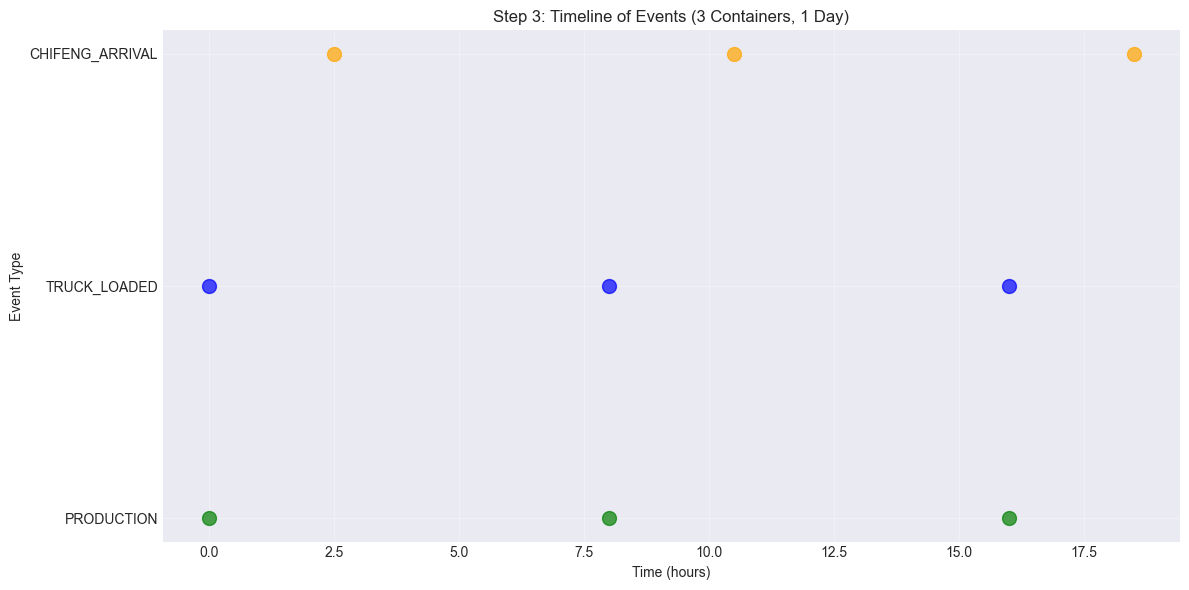

In [14]:
# ### Step 3 Visualization: Timeline of Events

# %%
def visualize_step3_timeline(model):
    """Visualize the timeline of events for Step 3"""
    events_df = model.logger.get_events_df()
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Color mapping for event types
    color_map = {
        'PRODUCTION': 'green',
        'TRUCK_LOADED': 'blue',
        'CHIFENG_ARRIVAL': 'orange',
        'TRAIN_DEPARTURE': 'red',
        'TIANJIN_ARRIVAL': 'purple'
    }
    
    # Plot events
    for event_type, color in color_map.items():
        events_subset = events_df[events_df['event_type'] == event_type]
        if not events_subset.empty:
            ax.scatter(events_subset['time'], [event_type] * len(events_subset), 
                      color=color, s=100, alpha=0.7)
    
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('Event Type')
    ax.set_title('Step 3: Timeline of Events (3 Containers, 1 Day)')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

visualize_step3_timeline(step3_model)
